In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp, AffineTransform
from numpy import pad
from skimage import io

In [8]:
# Generate a simple chessboard image
def create_chessboard(size=100, block_size=10):
    image = np.zeros((size, size))
    for i in range(size // block_size):
        for j in range(size // block_size):
            if (i + j) % 2 == 0:
                image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size] = 1
    return image

create_chessboard(100, 10)

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [19]:
 # Generate 125 strain tensors
def generate_strain_tensors():
    strain_xx = np.linspace(-0.5, 2, 5)  # Stretching values
    strain_yy = np.linspace(-0.5, 2, 5)  # Stretching values
    # shear_xy1 = np.linspace(-0.9, -0.5, 2)   # Shear strain
    # shear_xy2 = np.linspace(0.5, 0.9, 2)   # Shear strain
    # shear_xy = np.concatenate((shear_xy1, [0], shear_xy2))
    shear_xy = np.linspace(-0.9, 0.9, 5)
    tensors = [
        (xx, yy, xy)
        for xx in strain_xx
        for yy in strain_yy
        for xy in shear_xy
    ]
    return tensors

In [10]:
# Perform polar decomposition
def polar_decomposition(F):
    U, S, Vt = np.linalg.svd(F)
    R = U @ Vt  # Rotation matrix
    U_stretch = Vt.T @ np.diag(S) @ Vt  # Pure strain component
    return R, U_stretch

# Create deformation gradient from strain tensor
def deformation_gradient_from_strain(strain_tensor):
    F = np.eye(2) + strain_tensor
    return F

# Apply transformation
def apply_corotated_strain(image, s):

    strain_tensor = np.array([[s[0], s[2]], 
                              [s[2], s[1]]])
    F = deformation_gradient_from_strain(strain_tensor)

    R, F_strain = polar_decomposition(F)

    # Build affine transform matrix (add homogeneous coordinates)
    F_strain_h = np.eye(3)
    F_strain_h[:2, :2] = F_strain

    # Center image for proper transformation
    center = np.array(image.shape) / 2
    translation_to_origin = np.eye(3)
    translation_to_origin[:2, 2] = -center

    translation_back = np.eye(3)
    translation_back[:2, 2] = center

    # Combine transformations
    affine_matrix = translation_back @ F_strain_h @ translation_to_origin
    transform = AffineTransform(matrix=affine_matrix)

    # Apply warp
    transformed_image = warp(
        image,
        inverse_map=transform.inverse,
        mode="constant",
        cval=0.0,
        preserve_range=True,
        order=3  # Bicubic interpolation
    )
    return transformed_image

In [11]:
# Display images in pages of 25
def display_images_in_pages(image, tensors, rows=5, cols=5):
    total_tensors = len(tensors)
    tensors_per_page = rows * cols
    pages = total_tensors // tensors_per_page + (1 if total_tensors % tensors_per_page else 0)

    for page in range(pages):
        print(f"Displaying page {page + 1} of {pages}")
        start_idx = page * tensors_per_page
        end_idx = start_idx + tensors_per_page
        tensors_on_page = tensors[start_idx:end_idx]

        fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
        axes = axes.ravel()

        for i, tensor in enumerate(tensors_on_page):
            deformed_image = apply_corotated_strain(image, tensor)

            height, width = deformed_image.shape[:2]
            center_y, center_x = height // 2, width // 2

            crop_size = 64
            top_left_y = center_y - crop_size // 2
            top_left_x = center_x - crop_size // 2

            # Crop the image
            cropped_patch = deformed_image[top_left_y:top_left_y + crop_size, top_left_x:top_left_x + crop_size]

            axes[i].imshow(deformed_image, cmap='gray', vmin=0, vmax=1)
            #axes[i].imshow(cropped_patch, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"{tensor[0]:.2f},{tensor[1]:.2f},{tensor[2]:.2f}")

        # Remove unused subplots
        for ax in axes[len(tensors_on_page):]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        # Pause to allow navigation between pages
        input(f"Press Enter to see the next page (page {page + 2} of {pages})...")

[(np.float64(-0.5), np.float64(-0.5), np.float64(-0.9)), (np.float64(-0.5), np.float64(-0.5), np.float64(-0.5)), (np.float64(-0.5), np.float64(-0.5), np.float64(0.0)), (np.float64(-0.5), np.float64(-0.5), np.float64(0.5)), (np.float64(-0.5), np.float64(-0.5), np.float64(0.9)), (np.float64(-0.5), np.float64(0.125), np.float64(-0.9)), (np.float64(-0.5), np.float64(0.125), np.float64(-0.5)), (np.float64(-0.5), np.float64(0.125), np.float64(0.0)), (np.float64(-0.5), np.float64(0.125), np.float64(0.5)), (np.float64(-0.5), np.float64(0.125), np.float64(0.9)), (np.float64(-0.5), np.float64(0.75), np.float64(-0.9)), (np.float64(-0.5), np.float64(0.75), np.float64(-0.5)), (np.float64(-0.5), np.float64(0.75), np.float64(0.0)), (np.float64(-0.5), np.float64(0.75), np.float64(0.5)), (np.float64(-0.5), np.float64(0.75), np.float64(0.9)), (np.float64(-0.5), np.float64(1.375), np.float64(-0.9)), (np.float64(-0.5), np.float64(1.375), np.float64(-0.5)), (np.float64(-0.5), np.float64(1.375), np.float64(

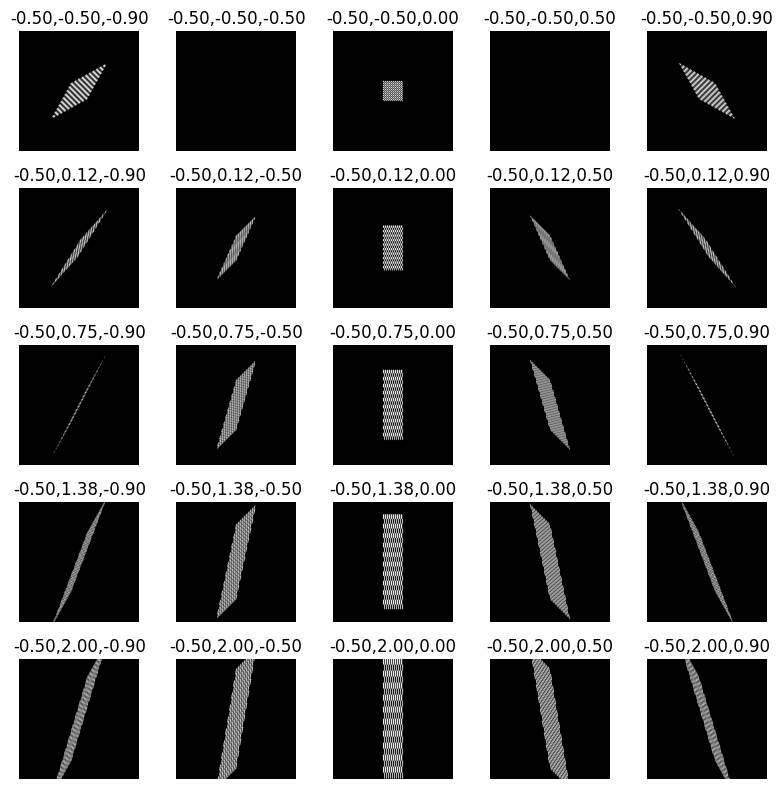

Displaying page 2 of 5


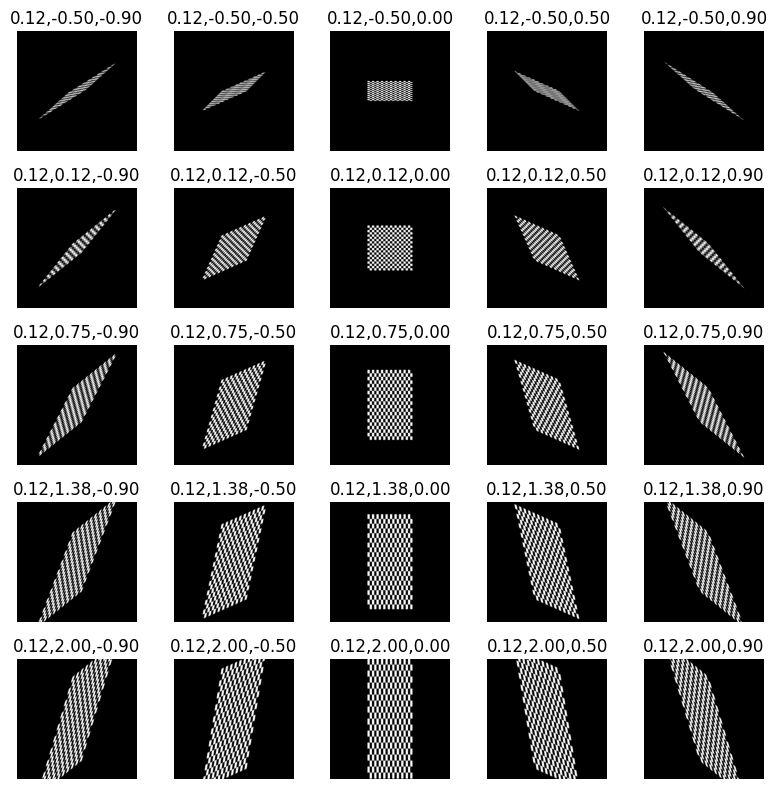

Displaying page 3 of 5


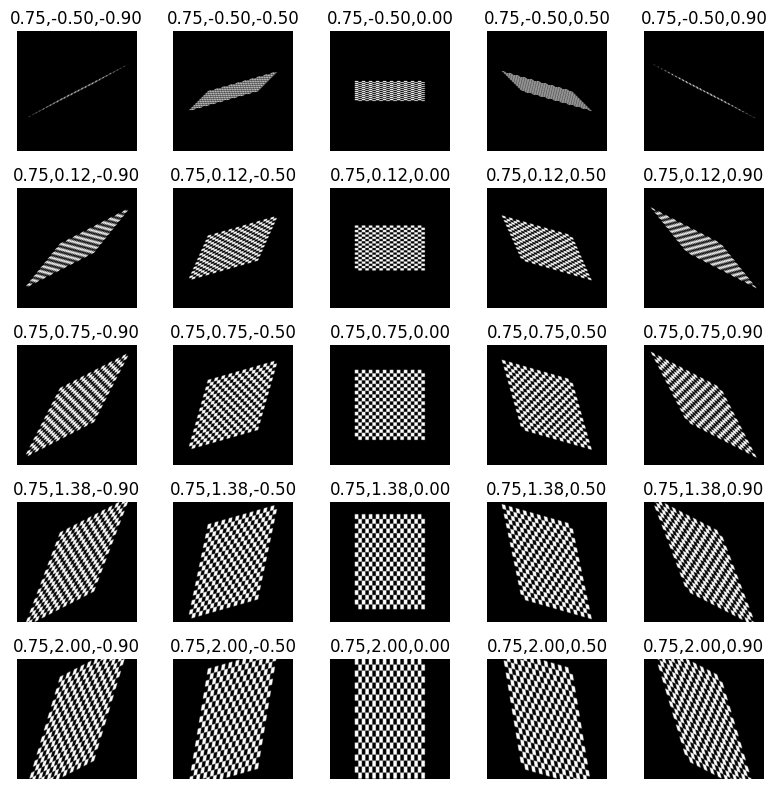

Displaying page 4 of 5


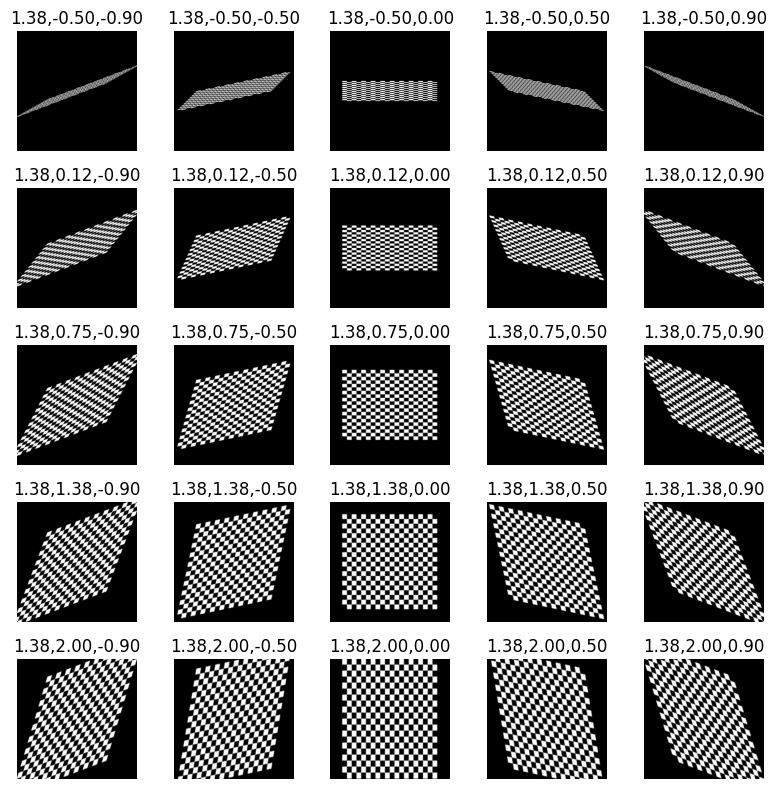

Displaying page 5 of 5


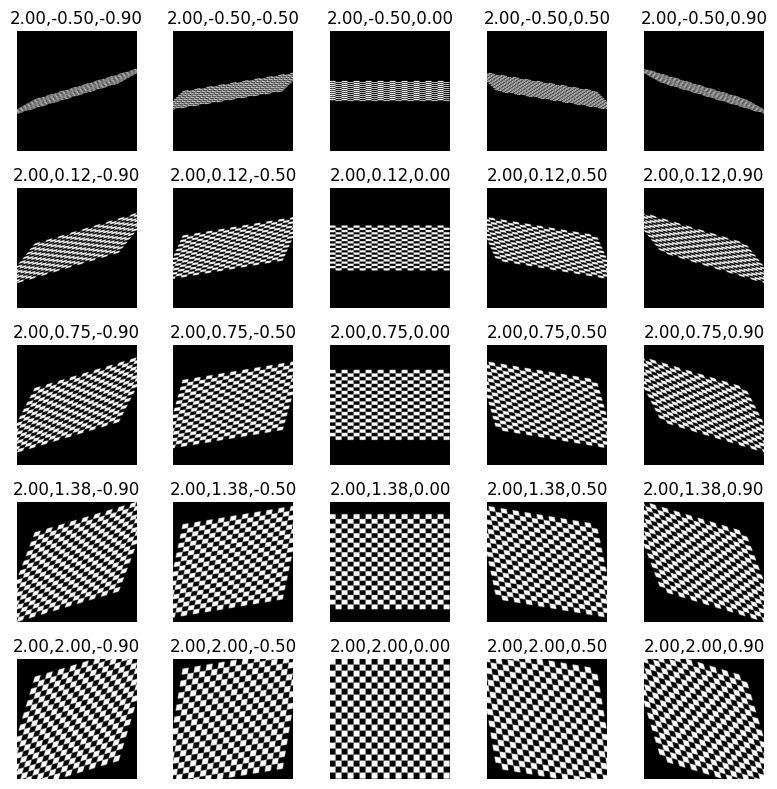

In [20]:
# Main
image_size = 100
block_size = 5
padding = 100  # Prevent clipping

# Create and pad chessboard image
image = create_chessboard(size=image_size, block_size=block_size)
image = pad(image, padding, mode="constant", constant_values=0)

# Generate strain tensors
strain_tensors = generate_strain_tensors()
print(strain_tensors)
    
# Display images in pages of 25
display_images_in_pages(image, strain_tensors)